In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
train = pd.read_csv('train_yaOffsB.csv')
test = pd.read_csv('test_pFkWwen.csv')
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [37]:
train.dtypes

ID                          object
Estimated_Insects_Count      int64
Crop_Type                    int64
Soil_Type                    int64
Pesticide_Use_Category       int64
Number_Doses_Week            int64
Number_Weeks_Used          float64
Number_Weeks_Quit            int64
Season                       int64
Crop_Damage                  int64
dtype: object

In [38]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [39]:
train.shape, test.shape

((88858, 10), (59310, 9))

In [40]:
test.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [41]:
train.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')

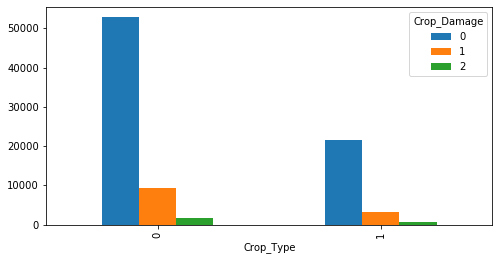

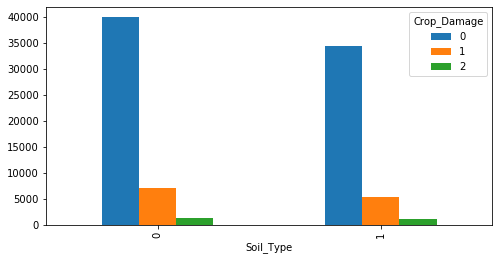

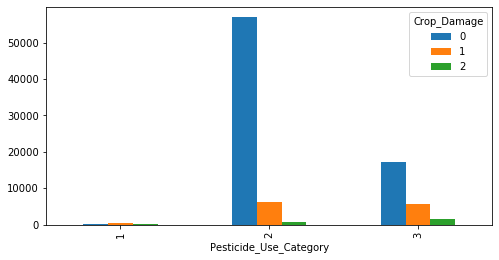

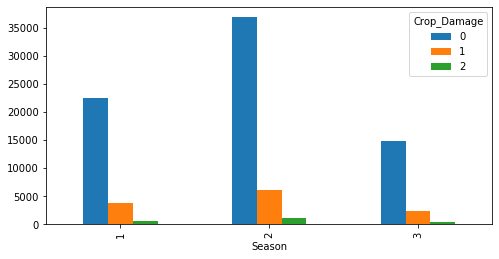

In [42]:
Crop_Type = pd.crosstab(train['Crop_Type'], train['Crop_Damage'])
Crop_Type.plot(kind='bar', figsize=(8, 4))
plt.show()

Soil_Type = pd.crosstab(train['Soil_Type'], train['Crop_Damage'])
Soil_Type.plot(kind='bar', figsize=(8, 4))
plt.show()

Pesticide_Use_Category = pd.crosstab(train['Pesticide_Use_Category'], train['Crop_Damage'])
Pesticide_Use_Category.plot(kind='bar', figsize=(8, 4))
plt.show()

Season = pd.crosstab(train['Season'], train['Crop_Damage'])
Season.plot(kind='bar', figsize=(8, 4))
plt.show()

In [43]:
train['Crop_Damage'].value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

In [44]:
agg_op = ['mean', 'max', 'min']

train.groupby('Crop_Damage')['Estimated_Insects_Count'].agg(agg_op)

,mean,max,min
Crop_Damage,,,
0,1315.707387,4097,150
1,1839.106200,4097,150
2,1731.111976,4097,150


In [45]:
train.groupby('Crop_Damage')['Number_Doses_Week'].agg(agg_op)

,mean,max,min
Crop_Damage,,,
0,26.119238,95,0
1,24.176079,95,0
2,26.113273,90,0


In [46]:
train.groupby('Crop_Damage')['Number_Weeks_Quit'].agg(agg_op)

,mean,max,min
Crop_Damage,,,
0,10.110644,50,0
1,7.630698,50,0
2,3.303934,47,0


In [47]:
train_idx = train[train['Number_Weeks_Used'].isnull()].index.tolist()
train.loc[train_idx, 'Number_Weeks_Used'] = train.loc[train_idx, 'Number_Doses_Week']

test_idx = test[test['Number_Weeks_Used'].isnull()].index.tolist()
test.loc[test_idx, 'Number_Weeks_Used'] = test.loc[test_idx, 'Number_Doses_Week']

In [48]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [49]:
X = train.drop(['Crop_Damage', 'ID'], axis=1)
y = train['Crop_Damage']

X_test = test.drop(['ID'], axis=1)

X.shape, y.shape, X_test.shape

((88858, 8), (88858,), (59310, 8))

In [51]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [57]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.5,
    'boost': 'gbdt',
    'feature_fraction': 0.7,
    'learning_rate': 0.05,
    'num_class':3,
    'metric':'multi_logloss',
    'max_depth': 5,  
    'num_leaves': 70,
    'min_data_in_leaf':40,
    'objective': 'multiclass',
    'scale_pos_weight':1,
    
    'verbosity': 1
}

In [58]:
folds = StratifiedKFold(n_splits=5, shuffle=True)
predictions = np.zeros((len(X_test), 3))
feature_importance_df = pd.DataFrame()
features = X.columns.tolist()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=1000, early_stopping_rounds = 1000)
    predictions_val = np.argmax(clf.predict(X.iloc[val_idx][features], num_iteration=clf.best_iteration), axis=1)
    
    print("Accuracy Score: ",accuracy_score(predictions_val, y.iloc[val_idx]))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold 0
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.382903	valid_1's multi_logloss: 0.424067
Early stopping, best iteration is:
[284]	training's multi_logloss: 0.404773	valid_1's multi_logloss: 0.42049
Accuracy Score:  0.846443844249381
Fold 1
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.381795	valid_1's multi_logloss: 0.427314
Early stopping, best iteration is:
[300]	training's multi_logloss: 0.403061	valid_1's multi_logloss: 0.42253
Accuracy Score:  0.8455435516542876
Fold 2
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.381852	valid_1's multi_logloss: 0.423806
Early stopping, best iteration is:
[283]	training's multi_logloss: 0.404716	valid_1's multi_logloss: 0.419985
Accuracy Score:  0.8463875759621877
Fold 3
Training until validation scores don't improve for 1000 rounds
[1000]	training's multi_logloss: 0.382518	valid_1's multi

In [59]:
predictions

array([[0.23333146, 0.75129906, 0.01536948],
       [0.15482073, 0.78191312, 0.06326615],
       [0.12464786, 0.75966225, 0.11568989],
       ...,
       [0.72350807, 0.26862789, 0.00786404],
       [0.79834475, 0.19514785, 0.0065074 ],
       [0.72273368, 0.26852225, 0.00874407]])